# Bulge Disk Decomposition (and other "multi-profile" fits)

In this guide, we'll briefly show the functionality for fitting multi-component profiles. Here, we will use a new `sersic_exp` profile, in which a sersic profile is fit to the inner portion of a galaxy, while the outer part is fit with the sersic index fixed to 1. An additional degree of flexibility can be added using `doublesersic`, in which the `n` for both profiles can vary. 

In [1]:
import jax.numpy as jnp
import numpy as np


# Load up one of the canonical example galaxies
def load_data(n):
    im = np.load(f"examp_gals/gal{n}_im.npy")
    mask = np.load(f"examp_gals/gal{n}_mask.npy")
    sig = np.load(f"examp_gals/gal{n}_sig.npy")
    psf = np.load(f"examp_gals/gal{n}_psf.npy")
    return im, mask, sig, psf


im, mask, sig, psf = load_data(2)

/Users/ipasha/miniforge3/envs/pysersic-14/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


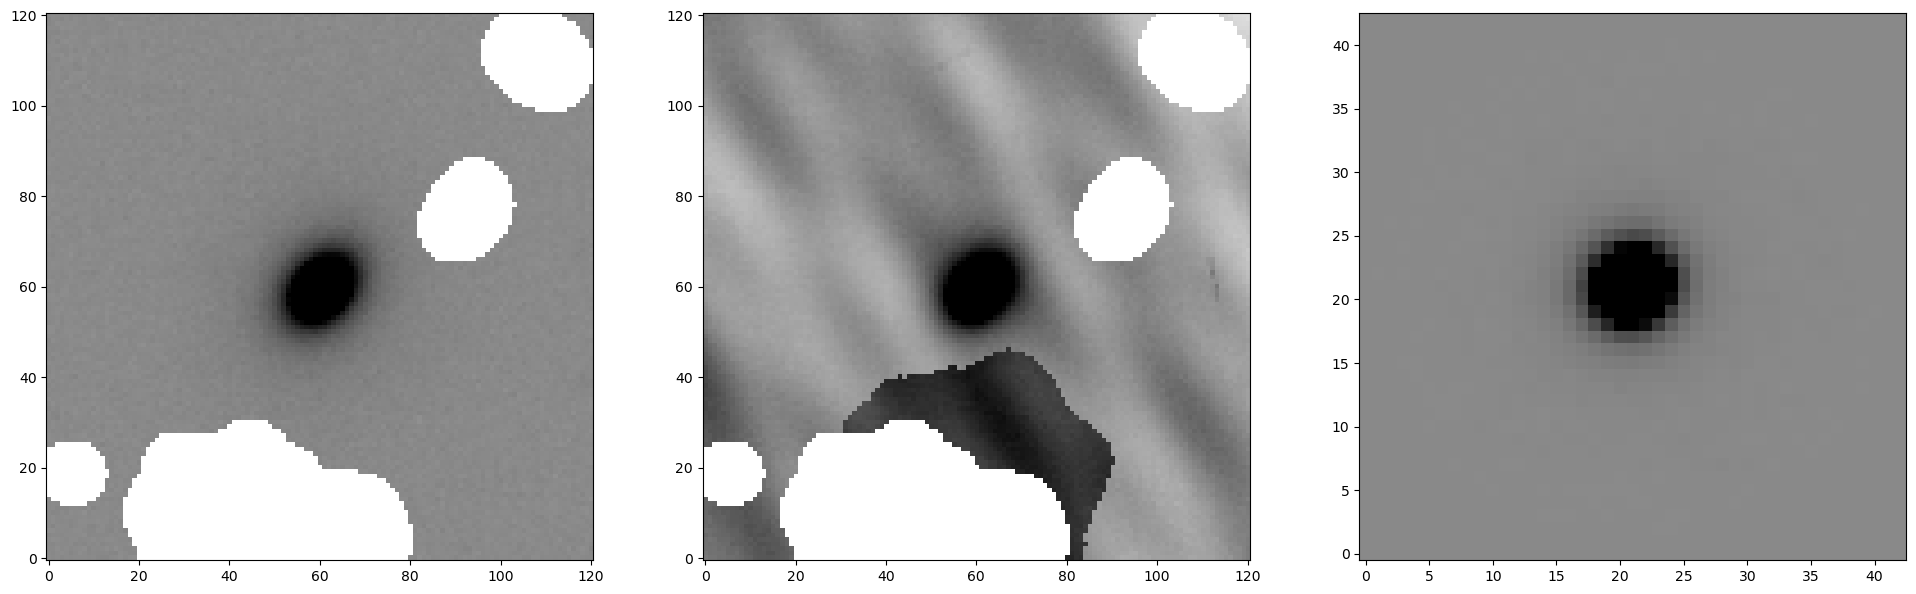

In [2]:
from pysersic.results import plot_image

fig, ax = plot_image(im, mask, sig, psf)

## Setting up the new Prior 

We have added an explict `sersic_exp` profile type to the list of supported options. This is similar to the `doublesersic`, but uses the `render_exp` to explicitly remove priors around the secondary "n". One can now fit a galaxy using the same `autoprior` function used in the docs:

In [3]:
from pysersic.priors import autoprior

prior = autoprior(image=im, profile_type="sersic_exp", mask=mask, sky_type="none")

In [4]:
prior

Prior for a sersic_exp source:
------------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00
f_1 ---  Uniform between: 0.00 -> 1.00
theta ---  Uniform between: 0.00 -> 6.28
r_eff_1 ---  Truncated Normal w/ mu = 4.10, sigma = 2.03, between: 0.50 -> inf
r_eff_2 ---  Truncated Normal w/ mu = 9.23, sigma = 3.04, between: 0.50 -> inf
ellip_1 ---  Uniform between: 0.00 -> 0.90
ellip_2 ---  Uniform between: 0.00 -> 0.90
n ---  Truncated Normal w/ mu = 4.00, sigma = 1.00, between: 0.65 -> 8.00
sky type - None

In brief, the formulation for this kind of fit includes

- `f_1`, the fraction of total flux contained within the inner (sersic) component. The fraction in the second (exponential) component is by definition `flux-f_1`. 
- `theta`, which is defined to be the same for both components at present
- `r_eff_1` and `r_eff_2`, the two effective radii of the two components. At present, `autoprior` simply sets the inner profile to be the measured `r_eff` from a simple call to `photutils` `data_properties` divided by 1.5, and the other one to be the same times 1.5. (One can always override these). `r_eff_1` should be smaller than `r_eff_2`. 
- `ellip_1` and `ellip_2` are treated fully independently. 
- `x_c` and `y_c` for the two models are constrained to be the precise same location. 

## Fitting

We can now proceed with fitting in the normal way:

In [5]:
from pysersic import FitSingle
from pysersic.loss import student_t_loss

fitter = FitSingle(
    data=im, rms=sig, mask=mask, psf=psf, prior=prior, loss_func=student_t_loss
)

In [6]:
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

map_params = fitter.find_MAP(rkey=PRNGKey(1000))

  1%|▏         | 251/20000 [00:00<00:51, 387.23it/s, Round = 2,step_size = 5.0e-04 loss: -1.592e+04]


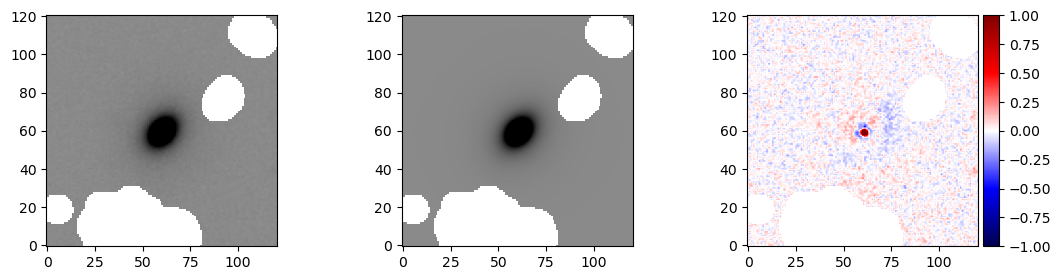

In [7]:
from pysersic.results import plot_residual

fig, ax = plot_residual(im, map_params["model"], mask=mask, vmin=-1, vmax=1)

As before, `map_params` is a simple dictionary with some parameters and one model instance corresponding to those parameters.

In [8]:
map_params

{'flux': Array(3731.5237, dtype=float32),
 'xc': Array(60.43279, dtype=float32),
 'yc': Array(59.26297, dtype=float32),
 'f_1': Array(0.75661, dtype=float32),
 'theta': Array(2.43743, dtype=float32),
 'r_eff_1': Array(4.32471, dtype=float32),
 'r_eff_2': Array(19.086239, dtype=float32),
 'ellip_1': Array(0.35005, dtype=float32),
 'ellip_2': Array(0.00014, dtype=float32),
 'n': Array(2.3921099, dtype=float32),
 'model': array([[0.00290311, 0.00291601, 0.00294391, ..., 0.00273432, 0.00272112,
         0.00270705],
        [0.00292037, 0.00294186, 0.00296349, ..., 0.00275073, 0.00272958,
         0.00272279],
        [0.00295186, 0.00296701, 0.00299746, ..., 0.00276646, 0.00275226,
         0.00273767],
        ...,
        [0.00271004, 0.00271845, 0.00272568, ..., 0.00298243, 0.00294799,
         0.00292868],
        [0.0027047 , 0.0027052 , 0.00272018, ..., 0.00295745, 0.00293191,
         0.00290587],
        [0.0026981 , 0.00270633, 0.0027137 , ..., 0.00294722, 0.00291496,
         0.

We can also run our methods to estimate or sample the posterior:

In [9]:
res = fitter.estimate_posterior(rkey=PRNGKey(1001), method="laplace")

  2%|▏         | 354/20000 [00:00<00:50, 388.89it/s, Round = 2,step_size = 5.0e-04 loss: -1.594e+04]


In [11]:
summary = fitter.svi_results.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [12]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip_1,0.221,0.004,0.212,0.228,0.000,0.000,881.0,790.0,NaN
ellip_2,0.598,0.008,0.581,0.612,0.000,0.000,941.0,850.0,NaN
f_1,0.868,0.004,0.861,0.875,0.000,0.000,978.0,908.0,NaN
flux,3996.181,17.292,3965.582,4029.488,0.545,0.385,1010.0,1023.0,NaN
n,4.665,0.077,4.528,4.804,0.002,0.002,971.0,912.0,NaN
r_eff_1,7.503,0.090,7.313,7.657,0.003,0.002,1094.0,1070.0,NaN
r_eff_2,5.047,0.068,4.928,5.185,0.002,0.001,1110.0,973.0,NaN
theta,2.439,0.003,2.434,2.443,0.000,0.000,984.0,1026.0,NaN
xc,60.438,0.003,60.433,60.443,0.000,0.000,992.0,969.0,NaN
yc,59.259,0.003,59.254,59.264,0.000,0.000,974.0,756.0,NaN


We can easily visualize the "mean model" from this SVI run by grabbing the parameter names and mean values:

In [15]:
dict = {}
for a, b in zip(summary.index, summary["mean"]):
    dict[a] = b

In [16]:
dict

{'ellip_1': 0.221,
 'ellip_2': 0.598,
 'f_1': 0.868,
 'flux': 3996.181,
 'n': 4.665,
 'r_eff_1': 7.503,
 'r_eff_2': 5.047,
 'theta': 2.439,
 'xc': 60.438,
 'yc': 59.259}

And passing them to one of our renderers, remembering to set our new profile type:

In [19]:
from pysersic.rendering import HybridRenderer

bf_model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(
    dict, profile_type="sersic_exp"
)

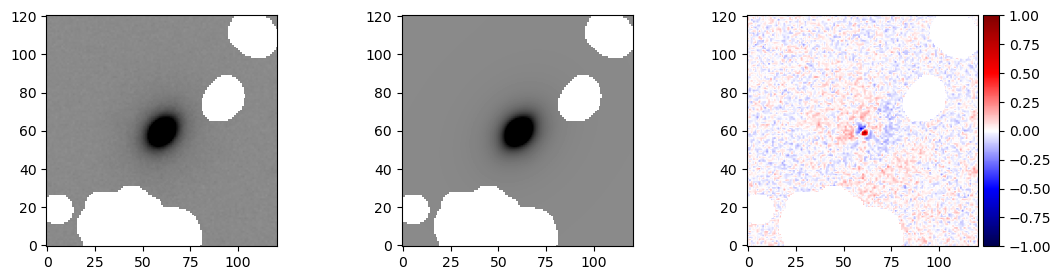

In [21]:
from pysersic.results import plot_residual

fig, ax = plot_residual(im, bf_model, mask=mask, vmin=-1, vmax=1)

## Further Steps

If you are interested in getting deeper into multi-component fitting, check out the "manual priors" tutorial. There you can see how to set all the priors of a `sersic_exp` or `doublesersic` profile to more specific bounds, if the autoprior is insufficient for your needs. If you have strong reasons to actually change the fitting nature (e.g., offset components spatially, or different `theta`s for the two components), please reach out and let us know. 